In [8]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from joblib import Parallel, delayed

import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [9]:
svi_vars = ['EP_POV150', 'EP_UNEMP', 'EP_HBURD', 'EP_NOHSDP', 'EP_UNINSUR', 'EP_AGE65',
            'EP_AGE17', 'EP_DISABL', 'EP_SNGPNT', 'EP_LIMENG', 'EP_MINRTY', 'EP_MUNIT',
            'EP_MOBILE', 'EP_CROWD', 'EP_NOVEH', 'EP_GROUPQ', 'EP_NOINT']

svi_df = pd.read_csv('../data/processed/merged_dataset.csv', usecols=svi_vars).dropna()

# Standardize variables to have mean 0 and variance 1. Use sklearn.preprocessing StandardScaler function
svi_standardize_df = StandardScaler().fit_transform(svi_df)

         0         1         2         3         4         5         6   \
0  0.233517 -1.285042 -1.002221 -0.504382  0.369429  1.067377  0.392566   
1 -0.945189 -2.547055 -1.285187 -0.140618  0.149862  0.447982  0.251507   
2 -1.274573  0.433791 -0.569580  0.725500 -1.222975  0.986163  0.672171   
3 -0.991040 -0.366071  0.831220 -0.481993  0.684692  0.382104  0.151210   
4 -1.776816 -1.025103 -0.400895  0.350233 -0.460791  0.687855 -0.249136   

         7         8         9         10        11        12        13  \
0 -0.090177 -0.123163 -0.006906 -0.341568 -0.272152  0.238669  0.674758   
1 -0.076648 -0.376272  0.586764  0.114936 -0.316238 -0.158544  0.434986   
2  0.535838 -0.618660  0.298388 -0.835360 -0.045716  0.400665 -0.353296   
3 -0.338145  0.559996  0.299080 -0.402265 -0.422682 -0.027112  0.674901   
4  0.251372  0.995051  0.440398  0.228677 -0.346596 -0.727630 -0.426702   

         14        15        16  
0  0.008718 -0.038625  0.367818  
1  0.076454  0.254773 -0.02623

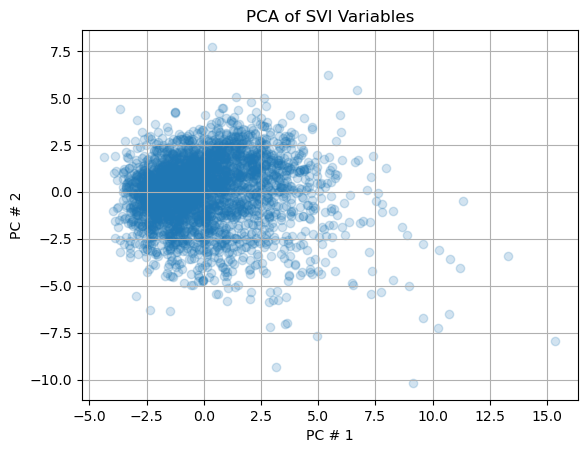

In [14]:
# get principal components
pca = PCA()
principal_components = pca.fit_transform(svi_standardize_df)
pca_df = pd.DataFrame(data=principal_components)
print(pca_df.head())

# Plot PCA 
plt.figure()
plt.scatter(pca_df[0], pca_df[1], alpha=0.2)
plt.xlabel('PC # 1')
plt.ylabel('PC # 2')
plt.title('PCA of SVI Variables')
plt.grid()
plt.show()


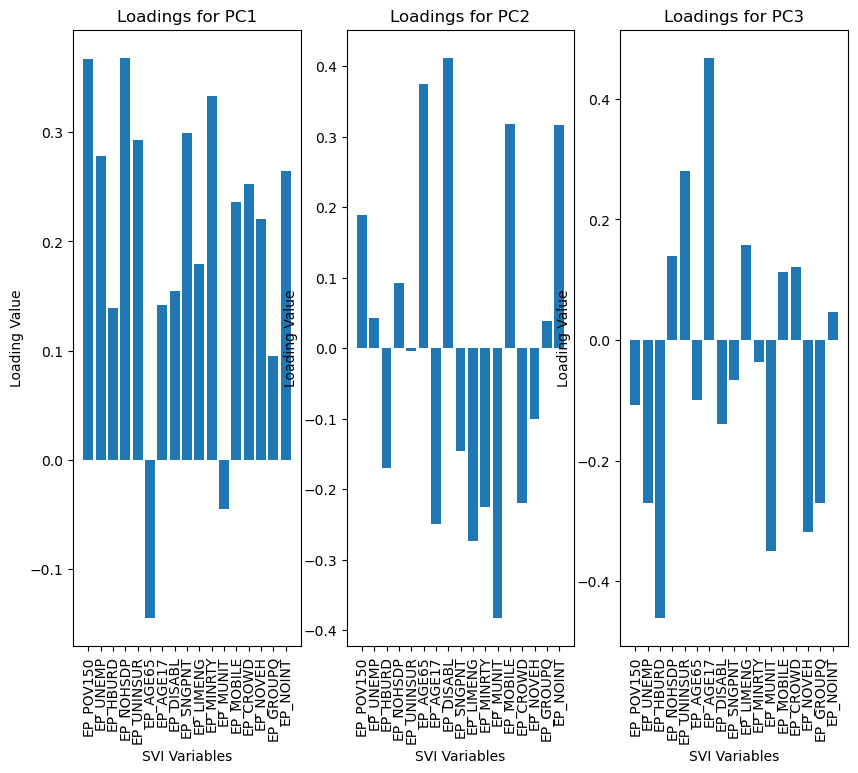


Interpretation

In PCA, loading values show how much each variable (x-axis) explains variance in each principal component (PC). Larger absolute loadings indicate strong influence, while small or near-zero values indicate weak influence.

PC1 appears to be a holistic measure of social vulnerability. Key variables are EP_POV10 (% below 150% poverty), EP_NOHSDP (% without HS degree), and EP_MINRTY (% minority), with EP_MUNIT (% in housing with 10+ units) showing the weakest influence, suggesting minimal dimension reduction without losing information.

PC2 represents social vulnerability specific to aged, disabled, and/or rural populations, with EP_DISABL (% disabled), EP_AGE65 (% age 65+), EP_MUNIT, EP_MOBILE (% mobile homes), and EP_NOINT (% without internet) being most influential. EP_UNINSUR, EP_GROUPQ, and EP_UNEMP have minimal impact, making them candidates for reduction.

PC3 captures vulnerability related to low-income urban youth, with EP_AGE17 (% age ≤17), EP_HBURD (% housing co

In [25]:
# Plot loadings for 1st 3 PCs
loadings = pca.components_
xlab = svi_vars

plt.figure(figsize=(10, 8))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.bar(xlab, loadings[i])
    plt.xticks(rotation=90)
    plt.xlabel('SVI Variables')
    plt.ylabel('Loading Value')
    plt.title(f'Loadings for PC{i+1}')
plt.show()



print("""\nInterpretation

In PCA, loading values show how much each variable (x-axis) explains variance in each principal component (PC). Larger absolute loadings indicate strong influence, while small or near-zero values indicate weak influence.

PC1 appears to be a holistic measure of social vulnerability. Key variables are EP_POV10 (% below 150% poverty), EP_NOHSDP (% without HS degree), and EP_MINRTY (% minority), with EP_MUNIT (% in housing with 10+ units) showing the weakest influence, suggesting minimal dimension reduction without losing information.

PC2 represents social vulnerability specific to aged, disabled, and/or rural populations, with EP_DISABL (% disabled), EP_AGE65 (% age 65+), EP_MUNIT, EP_MOBILE (% mobile homes), and EP_NOINT (% without internet) being most influential. EP_UNINSUR, EP_GROUPQ, and EP_UNEMP have minimal impact, making them candidates for reduction.

PC3 captures vulnerability related to low-income urban youth, with EP_AGE17 (% age ≤17), EP_HBURD (% housing cost-burdened), EP_MUNIT, EP_NOVEH (% without vehicle), and EP_UNINSUR as key indicators. Here, housing, uninsurance, crowding, and unemployment are prominent issues.""")



In [24]:
# Show the PCs and explained variance
expl_var_ratio = pca.explained_variance_ratio_
cum_var = np.cumsum(expl_var_ratio)
print(f"Cumlative Variance = {cum_var}")

print("\n7 of the 17 principal components are need to explain 80% of variance in the data, and 11 principal components are needed to explain 90%.")

Cumlative Variance = [0.28225876 0.4739652  0.5822437  0.6502753  0.70956421 0.76676665
 0.80321315 0.83746826 0.86699189 0.89324414 0.9178372  0.93921462
 0.95622191 0.9706734  0.98228445 0.99164404 1.        ]

7 of the 17 principal components are need to explain 80% of variance in the data, and 11 principal components are needed to explain 90%.


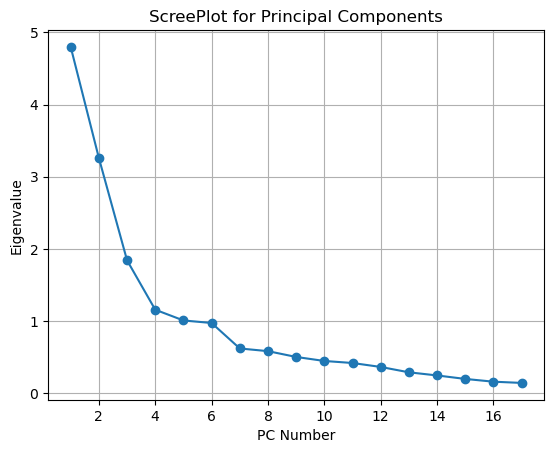

The 'elbow' is between principal components 4 and 7. We should retain 4 to 7 depending on our where we choose to specify the elbow. 7 principal components would keep the most information but perhaps more noise. The ScreePlot declines very slowly after 4 so there is relatively little to gain using more than 4 principal components.


In [26]:
# ScreePlot of eigenvalues/loading values in the PCs
plt.figure()
plt.plot(range(1, len(expl_var_ratio) + 1), pca.explained_variance_, marker='o')
plt.xlabel('PC Number')
plt.ylabel('Eigenvalue')
plt.title('ScreePlot for Principal Components')
plt.grid()
plt.show()

print("The 'elbow' is between principal components 4 and 7. We should retain 4 to 7 depending on our where we choose to specify the elbow. 7 principal components would keep the most information but perhaps more noise. The ScreePlot declines very slowly after 4 so there is relatively little to gain using more than 4 principal components.")



In [18]:
# approximates the data matrix X using the first k principal components
# X must be standardized to have mean 0 and standard deviation 1
 
np.random.seed(123)

def pca_approx(X, k):
    U, S, Vt = np.linalg.svd(X, full_matrices=False)
    Uk = U[:, :k]
    Sk = np.diag(S[:k])
    Vtk = Vt[:k, :]
    return Uk @ Sk @ Vtk
# In [101]:
# computes the cross-validated error of approximating X using the first k principal components
# X must be standardized to have mean 0 and standard deviation 1
# folds is a matrix of the same size as X with integers from 1 to n
# typically folds will have the numbers 1:n randomly assigned for each element

def pca_cv_error(X, k, folds):
    fs = np.unique(folds)

    # Get the mean of each column of X
    means = np.mean(X, axis=0)

    # Initialize the array to store the errors
    errs = np.zeros(len(fs))

    # Loop over the folds
    for idx, f in enumerate(fs):
        # Create a copy of X with the values of fold f replaced by the column means
        X_cv = X.copy()

        # Replace values with column means for fold f
        for i in range(X.shape[1]):
            for j in range(X.shape[0]):
                if folds[j, i] == f:
                    X_cv[j, i] = means[i]

        # Approximate X_cv using the first k principal components
        X_hat = pca_approx(X_cv, k)

        # Compute the error of the approximation for only the replaced values
        err = 0.0
        for i in range(X.shape[1]):
            for j in range(X.shape[0]):
                if folds[j, i] == f:
                    err += (X_hat[j, i] - X[j, i])**2
        errs[idx] = err

    # Return the average error
    return np.sum(errs) / X.size

In [19]:

# call the DF
svi_df

# convert the data to a matrix and standardize it
X = svi_df.to_numpy().astype(float)
mu = np.mean(X, axis=0) # Mean
sd = np.std(X, axis=0) # Standard deviation

X = (X - mu) / sd

# create a matrix of random folds
n_folds = 20
folds = np.random.randint(1, n_folds + 1, size=svi_standardize_df.shape)


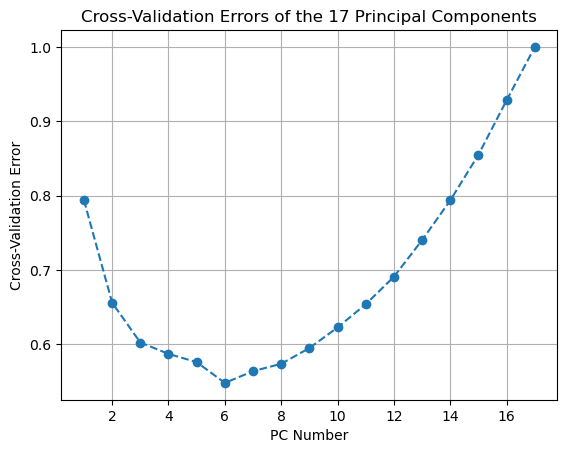

In [20]:

# Cross-validation errors for the 17 principal components
cross_val_errors = Parallel(n_jobs=-1)(            
    delayed(pca_cv_error)(svi_standardize_df, k, folds) for k in range(1, 18)
)

# Plot the cross validation errors
plt.figure()
plt.plot(range(1, 18), cross_val_errors, marker='o', linestyle='--')
plt.xlabel('PC Number')
plt.ylabel('Cross-Validation Error')
plt.title('Cross-Validation Errors of the 17 Principal Components')
plt.grid()
plt.show()

print(""""Based on the cross-validation errors, we should only keep the first six principal components.
We minimize the error at the 6th principal component.
Our model overfits the training data when it uses more than the first 6 principal components.""")